# Recognizing handwritten signatures
We hope to distinguish between real and forged signatures

In [1]:
# import required modules, packages
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.svm import SVC
%matplotlib inline

# import datasets, classifiers, performance metrics
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

In [2]:
# accessing the dataset
from PIL import Image, ImageFile, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

p = Path("sample_Signature/")
dirs = p.glob("*")
labels_dict = {'forged':0, 'genuine':1}

image_data = []
labels = []

for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1][:]

    for img_path in folder_dir.glob("*.png"):
        # reading/opens each image
        img = Image.open(img_path)
        if 'L' in img.getbands():  # image is black-and-white, colorize it
            img = ImageOps.colorize(img, black="blue", white="white")
        # resizing each image
        img_new = img.resize((200,200))
        # convert each image to array using numpy
        img_array = np.asarray(img_new)
        # append each image array to image_data list
        image_data.append(img_array)
        # match the label to corresponding image
        labels.append(labels_dict[label])

        # image color inversion
        from skimage import util
        import numpy as np
        color_inversion_img = util.invert(img_array)
        # alternate method with numpy
        #color_inversion_img_w_np = np.invert(img)
        img_invert_array = np.asarray(color_inversion_img)
        # append each image array to image_data list
        image_data.append(img_invert_array)
        # match the label to corresponding image
        labels.append(labels_dict[label])

        # change contrast
        import numpy as np
        from skimage import exposure
        v_min, v_max = np.percentile(img_array, (0.2, 99.8))
        better_contrast_img = exposure.rescale_intensity(img_array, in_range=(v_min, v_max))
        img_contrast_array = np.asarray(better_contrast_img)
        # append each image array to image_data list
        image_data.append(img_contrast_array)
        # match the label to corresponding image
        labels.append(labels_dict[label])

        # gamma correction
        adjusted_gamma_img = exposure.adjust_gamma(img_array, gamma=0.4, gain=0.9)
        img_gamma_array = np.asarray(adjusted_gamma_img)
        # append each image array to image_data list
        image_data.append(img_gamma_array)
        # match the label to corresponding image
        labels.append(labels_dict[label])

        # logarithmic correction
        log_correction_img = exposure.adjust_log(img_array)
        img_log_array = np.asarray(log_correction_img)
        # append each image array to image_data list
        image_data.append(img_log_array)
        # match the label to corresponding image
        labels.append(labels_dict[label])

        # sigmoid correction
        sigmoid_correction_img = exposure.adjust_sigmoid(img_array)
        img_sigmoid_array = np.asarray(sigmoid_correction_img)
        # append each image array to image_data list
        image_data.append(img_sigmoid_array)
        # match the label to corresponding image
        labels.append(labels_dict[label])

In [3]:
print(len(image_data))
print(len(labels))

1800
1800


In [4]:
image_data = np.array(image_data, dtype = 'float32')/255.0
labels = np.array(labels)

print(image_data.shape, labels.shape)

(1800, 200, 200, 3) (1800,)


In [5]:
import random 
combined = list(zip(image_data, labels))
random.shuffle(combined)

image_data[:], labels[:] = zip(*combined)

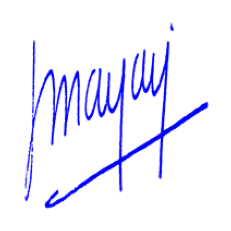

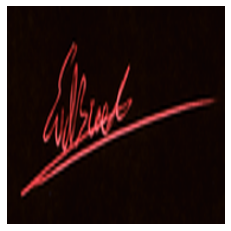

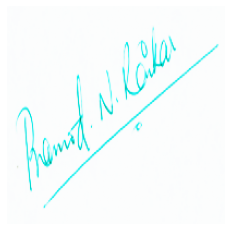

In [6]:
def drawImg(img):
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return

# example visualizations
for i in range(3):
    drawImg(image_data[i])

# Keras Classification

In [7]:
# updated model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(96, kernel_size=(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),    
    tf.keras.layers.Flatten(input_shape=(200,200,3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [8]:
# choose train, test size
image_train, image_test, label_train, label_test = train_test_split(
    image_data, labels, test_size =0.8, shuffle = False)

In [9]:
# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
model.fit(image_train, label_train, epochs = 15)

Epoch 1/15
12/12 [==============================] - 13s 1s/step - loss: 1.1890 - accuracy: 0.4833
Epoch 2/15
12/12 [==============================] - 12s 984ms/step - loss: 0.6927 - accuracy: 0.5111
Epoch 3/15
12/12 [==============================] - 12s 982ms/step - loss: 0.6919 - accuracy: 0.5361
Epoch 4/15
12/12 [==============================] - 12s 988ms/step - loss: 0.6852 - accuracy: 0.5556
Epoch 5/15
12/12 [==============================] - 12s 995ms/step - loss: 0.6668 - accuracy: 0.5556
Epoch 6/15
12/12 [==============================] - 15s 1s/step - loss: 0.6403 - accuracy: 0.6000
Epoch 7/15
12/12 [==============================] - 13s 1s/step - loss: 0.5948 - accuracy: 0.6361
Epoch 8/15
12/12 [==============================] - 12s 1s/step - loss: 0.5214 - accuracy: 0.7417
Epoch 9/15
12/12 [==============================] - 12s 1s/step - loss: 0.4919 - accuracy: 0.7639
Epoch 10/15
12/12 [==============================] - 12s 1s/step - loss: 0.4198 - accuracy: 0.8083
Epoch 1

In [11]:
test_loss, test_acc = model.evaluate(image_test, label_test, verbose = 10)
print('\nTest accuracy:', test_acc)


Test accuracy: 0.6222222447395325


# Serialization


In [12]:
# check if a model has already been saved and if it hasn't, save it to the disk
# this is basically the serialization
'''import os.path
if os.path.isfile('models/Real_Forged_signatures.h5') is False:
    model.save('models/Real_Forged_signatures.h5')
    '''
json_string = model.to_json()

In [13]:
import json

# writing to json file
with open("2021-09-22-keras.json", "w") as my_file:
    json_object = json.dump(json_string, my_file)

# previewing content
json_str = json.dumps(json_string)
print(json_str)

"{\"class_name\": \"Sequential\", \"config\": {\"name\": \"sequential\", \"layers\": [{\"class_name\": \"InputLayer\", \"config\": {\"batch_input_shape\": [null, 200, 200, 3], \"dtype\": \"float32\", \"sparse\": false, \"ragged\": false, \"name\": \"conv2d_input\"}}, {\"class_name\": \"Conv2D\", \"config\": {\"name\": \"conv2d\", \"trainable\": true, \"dtype\": \"float32\", \"filters\": 32, \"kernel_size\": [3, 3], \"strides\": [1, 1], \"padding\": \"valid\", \"data_format\": \"channels_last\", \"dilation_rate\": [1, 1], \"groups\": 1, \"activation\": \"relu\", \"use_bias\": true, \"kernel_initializer\": {\"class_name\": \"GlorotUniform\", \"config\": {\"seed\": null}}, \"bias_initializer\": {\"class_name\": \"Zeros\", \"config\": {}}, \"kernel_regularizer\": null, \"bias_regularizer\": null, \"activity_regularizer\": null, \"kernel_constraint\": null, \"bias_constraint\": null}}, {\"class_name\": \"MaxPooling2D\", \"config\": {\"name\": \"max_pooling2d\", \"trainable\": true, \"dtype\

# Deserialization

In [14]:
# Deserialization
#from tensorflow.keras.models import model_from_json
#model_architecture = model_from_json(json_string)

with open("2021-09-22-keras.json", "r") as my_file_read:
    my_list = json.load(my_file_read)

print(my_list)

{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 200, 200, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d", "trainable": true, "dtype": "float32", "pool_size": [2, 2], "padding": "valid", "strides": [2, 2], "data_format": "channels_last"}}, {"class